In [2]:
from src.logger import logging
try:
    # sklearn
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
    from sklearn.preprocessing import minmax_scale, StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.semi_supervised import LabelSpreading
    from sklearn.decomposition import PCA
    from sklearn.svm import SVC
    
    import sklearn
    sklearn.set_config(enable_metadata_routing=True)
    # visualization
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # stats
    from scipy.stats import chi2_contingency
    import scipy.stats as stats

    # handling data
    import pandas as pd
    import numpy as np
    pd.set_option("display.max_rows", 100)
    #handling other resources 
    import os, sys, re, inspect
    import warnings
    DeprecationWarning('ignore')
    warnings.filterwarnings('ignore')
    print('Modules imported sucessfully...')
        
except Exception as err:
    logging.info(err)
    

/Users/goldyrana/work/ATU/Sem1/predictive/t_project1/credit_card_approval_prediction/notebooks/logs/2023_12_22
2023_12_2209_37_16.log
Modules imported sucessfully...


In [3]:
class helper:
    def __init__(self):
        pass
    
    def check_results(cls, p_value, null, alternate, func_name= None):
        if p_value < 0.05: # Usually there is a differnce
            print(f"The {func_name} test result is statistically significant (p-value = {p_value}).")
            print(alternate)
        else: # accept null: Usually there is no difference
            print(f"The {func_name} test result is not statistically significant (p-value = {p_value}).")    
            print(null)
    
    @staticmethod
    def seprate_null(data, with_column):
        null = data[data[with_column].isnull()]
        not_null = data[data[with_column].notnull()]
        return null, not_null
    
    @staticmethod     
    def check_null(data):
        print(round(data.isnull().sum() / len(data) * 100, 2))
    
    @staticmethod
    def drop_columns(data, columns: list, inplace):
        return data.drop(columns, inplace = inplace, axis= 1)
    
    @staticmethod  
    def create_label(data, column, mapper):
        '''return pandas dataframe'''
        data[column] = data[column].map(mapper)
        return data
    
    @staticmethod
    def lower_name(data):
        data.columns = [column.lower() for column in data.columns]
        return data
    
    @staticmethod
    def split_x_y( data, y):
        y = data.pop(y)
        return data, y
    
    @staticmethod
    def transform(data, fitter):
        for col, fit in fitter.items():
            if data[col].isnull().sum() > 0: print(f'Warning: {col} having null values')
            try:
                data[col] = fitter[col].transform(data[col])
                print(fit, "is missing from the data")
            except:
                pass 
        return data
    
    @staticmethod
    def fit_model(estimator, train_x, train_y, test_x, test_y):
        estimator.fit(train_x, train_y)
        train_prediction = estimator.predict(train_x)
        test_prediction = estimator.predict(test_x)
        return estimator, train_prediction, test_prediction
                  
        
    
class preprocessing(helper):
    
    def __init__(self):
        super().__init__()
        
    def join_data(self, df1, df2, how = 'left', on = 'id', suffix = 'main'):
        return df1.join(df2, how = how, on = on, lsuffix=suffix)
            
    def mann_whitney(self, x, y, null, alternate):
        statistic, p_value = stats.mannwhitneyu(x, y)
        print(p_value)
        super().check_results(p_value, null = null, alternate = alternate,  func_name= inspect.currentframe().f_code.co_name)            
        
    def chi_test(self, data:pd.DataFrame, x:str, y:str, null, alternate):
        chi2_stat, p_value, dof, expected  = chi2_contingency(pd.crosstab(data[x], data[y]))
        super().check_results(p_value, null, alternate)
        
        
    def vintage_analysis(self, data, return_half = False):
        # functions will be called 
        mapper = {'0': 1, '1': 1, '2': 2, '3':3, '4':4, '5':5, 'C': -1, 'X': 0 } # to create labels
        data = helper.create_label(data, 'status', mapper)        
        # print(data.head(5))
        if return_half: return data  # to return data with new label only, not aggregated
        # Aggregating by the sum of column 'label'
        data_with_label = data.groupby('id').agg({'status': 'sum'})

        def _create_label(x) -> int:
            if x < 0:
                return -1
            elif x >= 5:
                return 5
            else:
                return x
    
        # create new labels 
        data_with_label['label'] =  data_with_label.status.apply(lambda x: _create_label(x))
        return data_with_label

    def fitter_label_encoder(self, data, columns: list):
        fitter = {}
        for column in columns:
            if data[column].isnull().sum() > 0: 
                print(f'Warning: {column} having null values')
                continue
            l_encoder = LabelEncoder()
            fitter.update({column: l_encoder.fit(data[column])})
        return fitter
    
    # def fill_null_values(self, data, estimator, y):
    #     null = data[data[y].isnull().index]
    #     not_null = data[data[y].notnull().index]
    #     estimator.fit(super().split_x_y(null, y))
    #     return estimator
        
        


help = helper()    
pre = preprocessing() 

In [4]:
df1 = pd.read_csv('/Users/goldyrana/work/ATU/Sem1/predictive/t_project1/credit_card_approval_prediction/data/raw/application_record.csv' )
df2 = pd.read_csv('/Users/goldyrana/work/ATU/Sem1/predictive/t_project1/credit_card_approval_prediction/data/raw/credit_record.csv' )


# Gathering information about the data
- Checking for head, tail, info, null values, shape
- Performing vintage analysis on credit record file
    - Checking uniuque counts 
    - Checking number of rows with respect to application_record file
    - Dropping any duplicates
    - Generating labels based on analysis (Vintage analysis)
    


In [5]:
# Lower the name of columns
df1 = pre.lower_name(df1)
df2 = pre.lower_name(df2)

In [6]:
# name of columns
df1.columns 

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members'],
      dtype='object')

In [7]:
df1.shape

(438557, 18)

In [8]:
df2.shape

(1048575, 3)

In [9]:
df1.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [10]:
df1.days_birth = round(abs(df1.days_birth/365), 2) # find the approximate age

In [11]:
df2.head(15)

,id,months_balance,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [12]:
# checking basic information about the 2 dataframes
print(f'df1 has {df1.id.nunique()} unique values in id')
print(f'df2 has {df2.id.nunique()} unique values in id')

df1 has 438510 unique values in id
df2 has 45985 unique values in id


In [13]:
helper.check_null(df1)

id                      0.0
code_gender             0.0
flag_own_car            0.0
flag_own_realty         0.0
cnt_children            0.0
amt_income_total        0.0
name_income_type        0.0
name_education_type     0.0
name_family_status      0.0
name_housing_type       0.0
days_birth              0.0
days_employed           0.0
flag_mobil              0.0
flag_work_phone         0.0
flag_phone              0.0
flag_email              0.0
occupation_type        30.6
cnt_fam_members         0.0
dtype: float64


In [14]:
helper.check_null(df2)

id                0.0
months_balance    0.0
status            0.0
dtype: float64


In [15]:
print(f"Shape of df1 is {df1.shape}\nShape of df2 is {df2.shape}")

Shape of df1 is (438557, 18)
Shape of df2 is (1048575, 3)


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   438557 non-null  int64  
 1   code_gender          438557 non-null  object 
 2   flag_own_car         438557 non-null  object 
 3   flag_own_realty      438557 non-null  object 
 4   cnt_children         438557 non-null  int64  
 5   amt_income_total     438557 non-null  float64
 6   name_income_type     438557 non-null  object 
 7   name_education_type  438557 non-null  object 
 8   name_family_status   438557 non-null  object 
 9   name_housing_type    438557 non-null  object 
 10  days_birth           438557 non-null  float64
 11  days_employed        438557 non-null  int64  
 12  flag_mobil           438557 non-null  int64  
 13  flag_work_phone      438557 non-null  int64  
 14  flag_phone           438557 non-null  int64  
 15  flag_email       

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1048575 non-null  int64 
 1   months_balance  1048575 non-null  int64 
 2   status          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [18]:
print(f"ID unique in df1 is {df1.id.nunique()}\nID unique in df2 is {df2.id.nunique()}")

ID unique in df1 is 438510
ID unique in df2 is 45985


In [19]:
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace = True)

# Vintage analysis: 
In credit risk, it is a popular method for managing credit risk. The term 'Vintage' refers to the month or quarter in which account was opened (loan was granted). In simple words, the vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted. Performance can be measured in the form of cumulative charge-off rate, proportion of customers 30/60/90 days past due (DPD)

In [20]:
df2.status.unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [21]:
df2[df2.id == 5150487] # one id can have multiple records

,id,months_balance,status
1048545,5150487,0,C
1048546,5150487,-1,C
1048547,5150487,-2,C
1048548,5150487,-3,C
1048549,5150487,-4,C
1048550,5150487,-5,C
1048551,5150487,-6,C
1048552,5150487,-7,C
1048553,5150487,-8,C
1048554,5150487,-9,C


# Version 1: Process used to perform vintage analysis
<span style="color:blue; font-weight:bold">__1. Understanding labels:__ </span><br>0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

__2. Setting rules__

<span style="color:green; font-weight:bold">Rule 1: </span><br> Set 0 -> 0, 1 to 1, 2 -> 2,... 5 -> 5, x (no loan) -> 0, C (paid off) -> -1. As c means they paid loan for the month i.e they acted as a good client, where x-> means it has no impact, where setting 0 -> will be calculated as one

<span style="color:green; font-weight:bold">Rule 2: </span><br> Adding the number using groupby ID as we have multiple records for 1 id and by adding numbers together, data will tell us how many times a customer acted as a good client or bad client. The issue here is number can go far in negative and positive direction which will be handled in coming analysis

<span style="color:green; font-weight:bold">Rule 3: </span><br> If a number after adding them together is -1 that means they acted as a good client, where any number above 0 (included) will be treated as a bad client. Although this rule will be modified based on the analysis captured through out the process. 


In [23]:
df2[df2.id == 5150487]  # just a random check to understand the ids and status

,id,months_balance,status
1048545,5150487,0,C
1048546,5150487,-1,C
1048547,5150487,-2,C
1048548,5150487,-3,C
1048549,5150487,-4,C
1048550,5150487,-5,C
1048551,5150487,-6,C
1048552,5150487,-7,C
1048553,5150487,-8,C
1048554,5150487,-9,C


In [24]:
df2 = pre.vintage_analysis(df2)

In [25]:
df2.head()

,status,label
id,,
5001711,3,3
5001712,1,1
5001713,0,0
5001714,0,0
5001715,0,0


In [26]:
data = pre.join_data(df1, df2, how = 'left', on = 'id')

<Axes: >

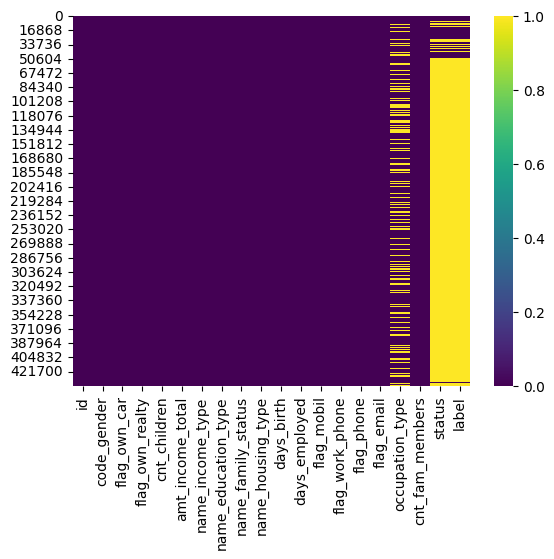

In [27]:
sns.heatmap(data.isnull(), cmap='viridis', cbar=True)

In [28]:
pre.check_null(data)

id                      0.00
code_gender             0.00
flag_own_car            0.00
flag_own_realty         0.00
cnt_children            0.00
amt_income_total        0.00
name_income_type        0.00
name_education_type     0.00
name_family_status      0.00
name_housing_type       0.00
days_birth              0.00
days_employed           0.00
flag_mobil              0.00
flag_work_phone         0.00
flag_phone              0.00
flag_email              0.00
occupation_type        30.60
cnt_fam_members         0.00
status                 91.69
label                  91.69
dtype: float64


#### looking at the above dataset, we can conclude that there are several null data points with the target variable
- Approch: Visualize the data and then apply semi-supervised machine learning to create lables, followed by building machine learning model

# Visualization

In [29]:
class visualization(helper):
    def __init__(self, data):
        super().__init__()
    
    def pie(self, data, column, title = ''):
        ratio = data[column].value_counts()
        plt.pie(ratio, labels= ratio.index, autopct='%1.1f%%')
        plt.title(column.replace("_", " ").title())
        plt.legend()
        plt.show()
        
    def create_graph(self, data, ignore_null = False):
        """Plot the pie or bar chart for object datatypes"""
        object_columns = data.select_dtypes(object).columns.to_list()
        for column in data.columns: # loop to add discrete columns in columns when object is passed 
            if data[column].nunique() < 10:
                object_columns.append(column)
        object_columns = list(set(object_columns))  # a measure to prevent duplicates columns
          
        # create list of hist columns
        hist_columns = []
        for column in data.columns: 
            if column not in object_columns:
                hist_columns.append(column)
        
        # code for creating pie and bar graph h              
        if ignore_null: # if data is null but want to be ignored
            for column in object_columns: 
                if data[column].nunique() >= 5:  # plot bar horizontal
                    calculate_ratio = data[column].value_counts()
                    plt.barh(calculate_ratio.index, calculate_ratio/len(data[column]))
                    plt.xticks(rotation = 45)
                    title = str(column).replace("_" ," ").title()
                    plt.title(title)
                    plt.show()
                else:   # plot pie chart
                    data[column] = data[column].dropna(inplace = False) # dropping null data point from column  
                    visualization.pie(self, data = data, column= column)
        
        else:   # if data is not null
            assert data[object_columns].isnull().sum().sum() ==0, 'Data having null values'
            for column in object_columns: # plot bar graph
                if data[column].nunique() > 6:
                    calculate_ratio = data[column].value_counts()
                    plt.barh(calculate_ratio.index, calculate_ratio/len(data[column]))
                    plt.title(column.replace("-", " ").title())
                    plt.xticks(rotation = 45)
                    plt.show()
                else:   # plot pie
                    visualization.pie(data, column)
                    
        # code to create histograms
        for column in hist_columns:
            sns.histplot(data[column], kde = True)
            plt.show()   
        
        sns.heatmap(data[hist_columns].corr('pearson'),annot=True,  cmap='coolwarm' )
        plt.show()          
          
vis = visualization(data)
        

In [30]:
null_frame, nn = vis.seprate_null(data, 'label')

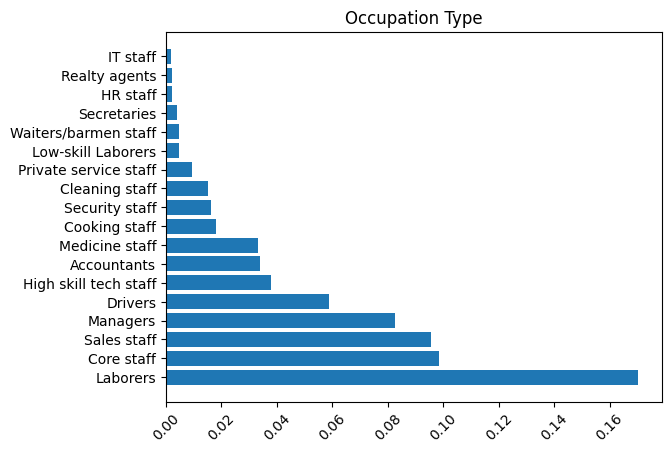

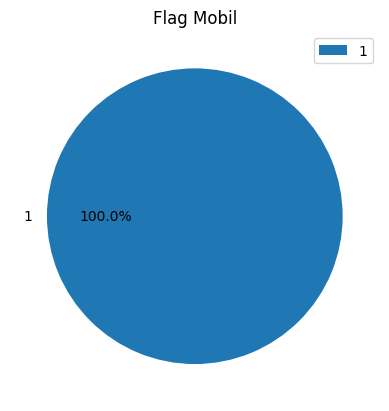

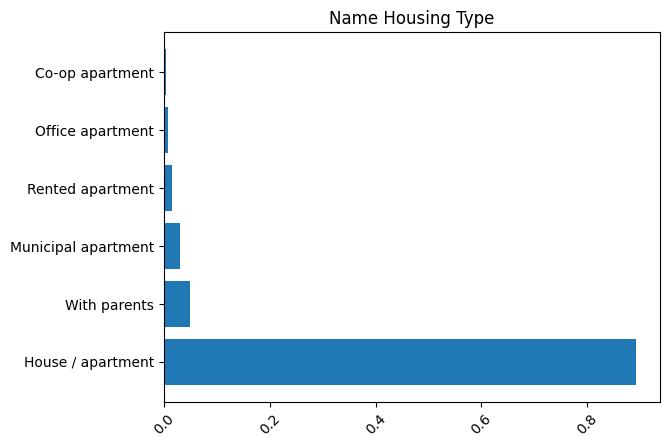

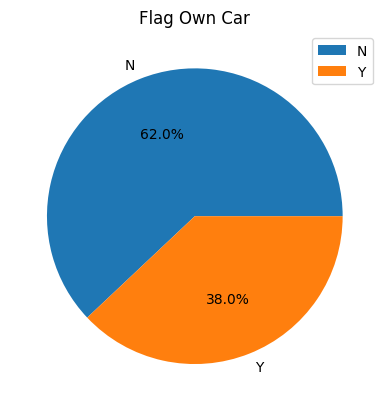

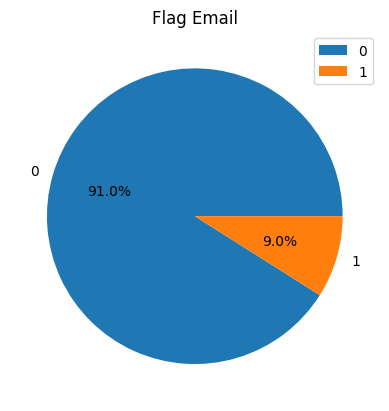

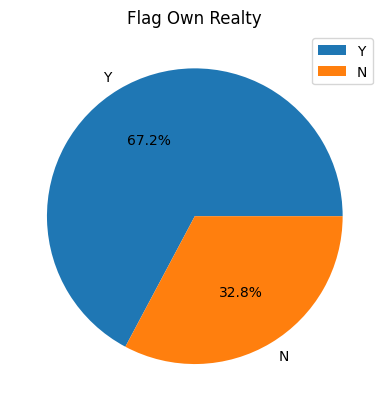

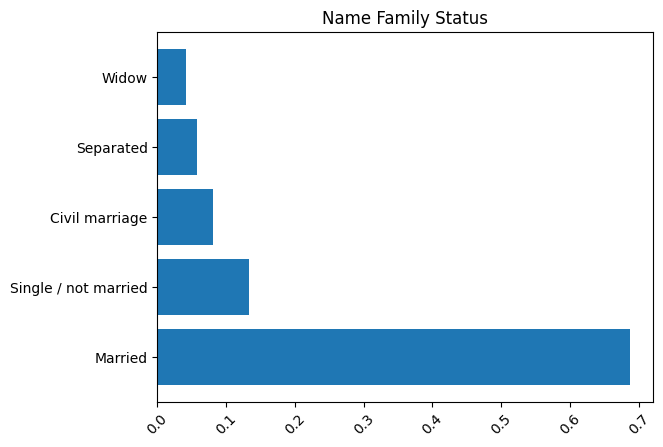

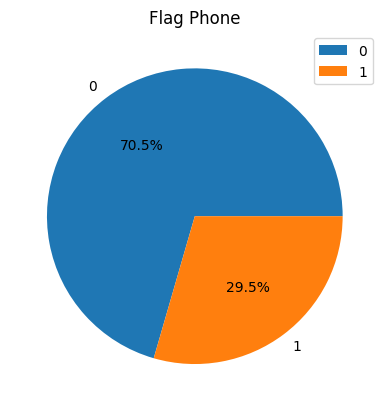

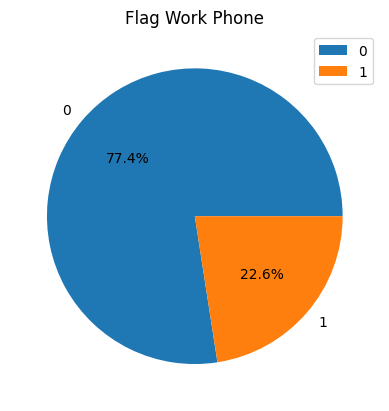

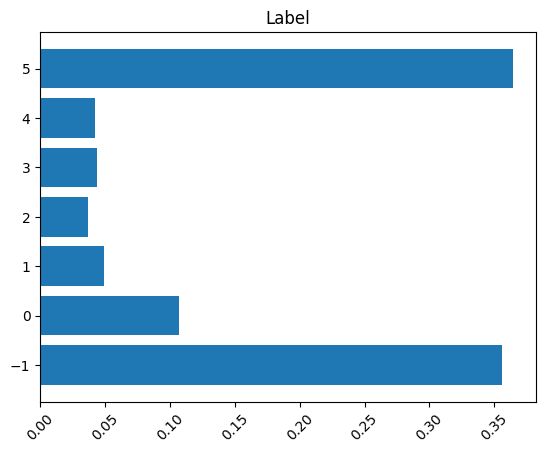

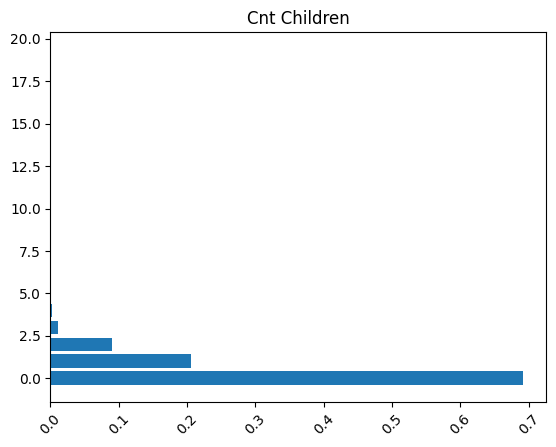

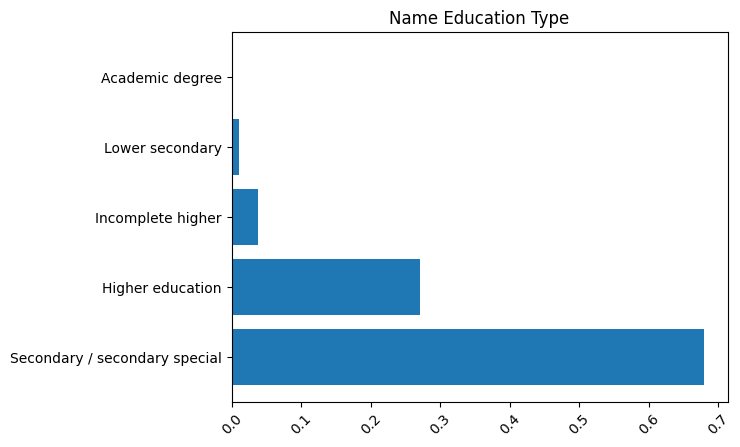

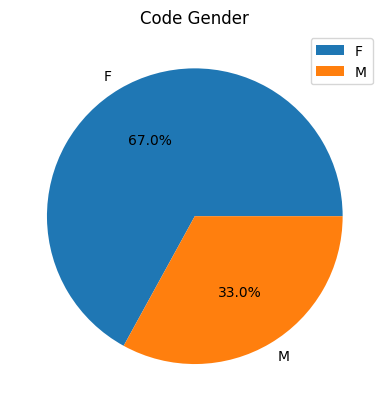

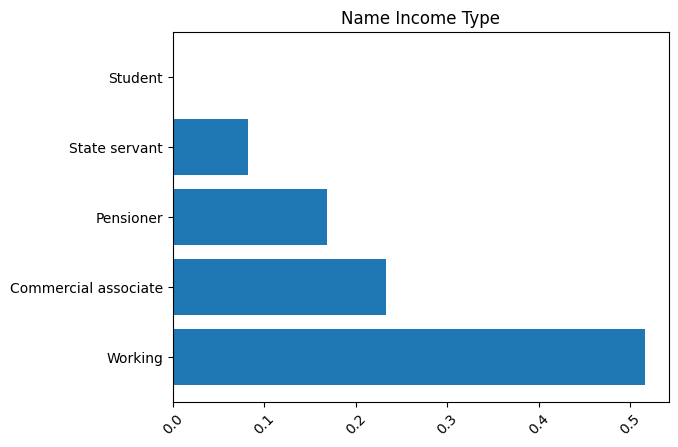

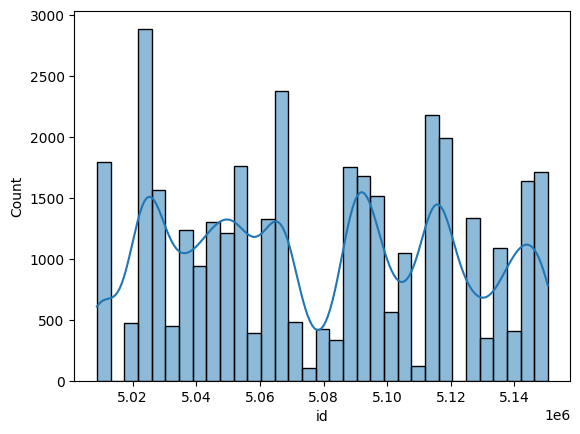

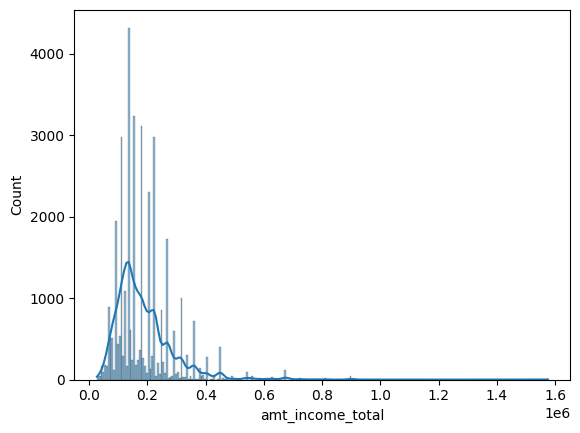

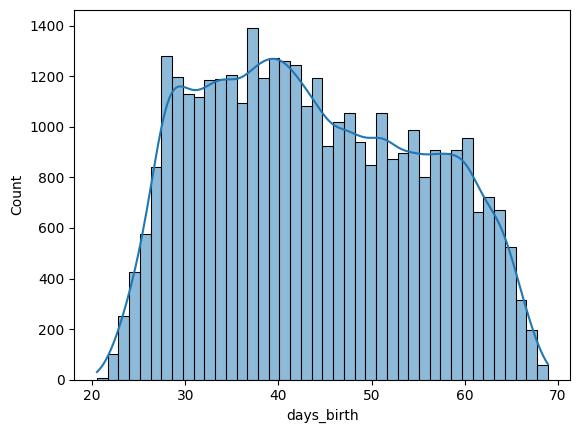

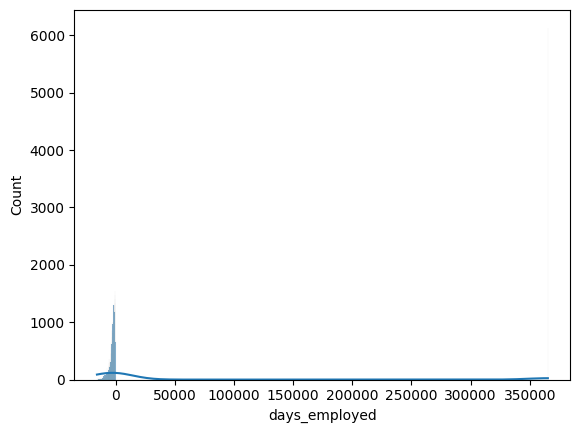

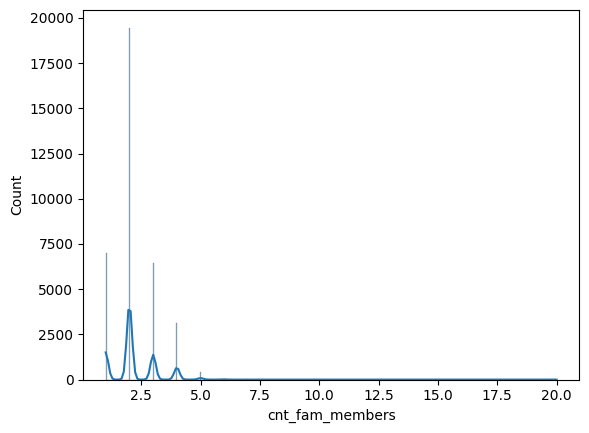

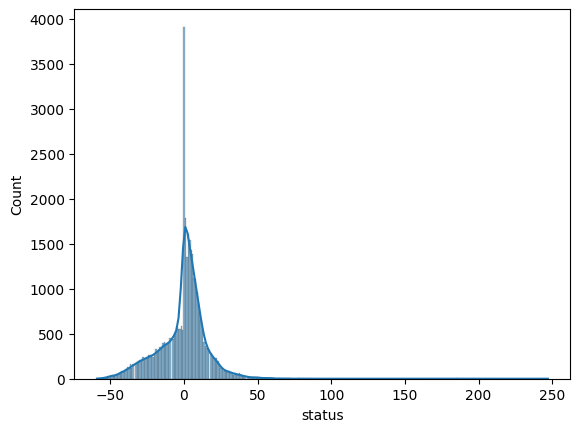

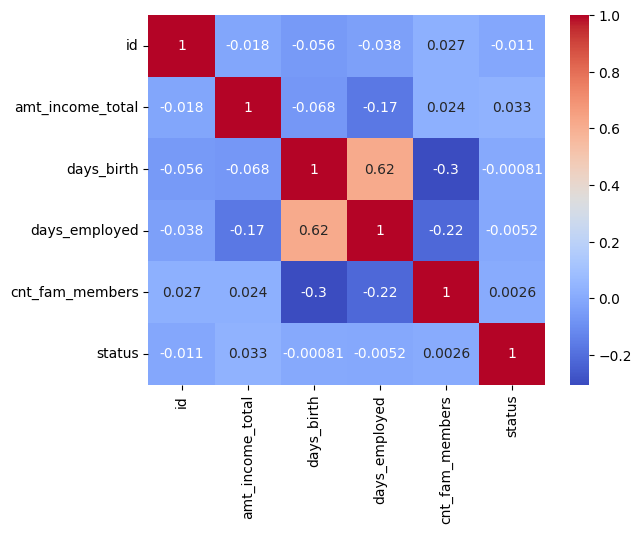

In [31]:
vis.create_graph(nn, ignore_null=True)

### Analytical checkups and their further analysis
- __<span style="color:blue; font-weight:bold">Work Phone: </span><br>__ 77.4% client are not having work phone
    - Is there any relation between work phone and being a good/bad client?
- __<span style="color:blue; font-weight:bold">Flag Phone: </span><br>__: 70% client are not having phone
    - Is there any impact on loan repayment between phone and client's behavious?
- __<span style="color:blue; font-weight:bold">Occupation Type: </span><br>__: Laborers are the top categories who had/have loan with bank followed by core staff and sales staff. 
    - Which of the occupation type is performing the worst in terms of repayment of loan? 
- __<span style="color:blue; font-weight:bold">Family Status: </span><br>__: Most of people are married. 
    - Is there any relation between family status and being a good/bad client? 
- __<span style="color:blue; font-weight:bold">Education Type: </span><br>__: Client's whose education status is secondary have applied for the loan in higher ratio. 
    - Which type of education type has higher impact on the loan?
- __<span style="color:blue; font-weight:bold">Car: </span><br>__: 62% of client has their own car
    - Do having own has has a impact on repayment of loan on time? 
- __<span style="color:blue; font-weight:bold">Gender: </span><br>__: 67% of female had/have loan with bank?
    - Does gender has impact on loan repayment? 
- __<span style="color:blue; font-weight:bold">House: </span><br>__: Most of client who have/had loan have their own house/apartment
    - Does repayment of loan has impact in which housing type a customer is living in ? 
- __<span style="color:blue; font-weight:bold">Label: </span><br>__: The ratio of being a good client (label: -1) is similar to being a wrost client (>= 5), where any category above/including 0 are bad client; however taking assumptions all client whose category is above/including 0 are bad client.
    - The scenario described above presents a significant issue, as it tends to categorize a majority of clients as 'bad clients,' resulting in a biased model. Since banks generate revenue by providing clients with credit cards, a machine learning model predicting a client as 'bad' may lead the bank to hesitate in offering a credit card, without being fully aware of the accuracy of this assessment."

Analytical checkups with continous variable

#### __Proposed solution__: Assign label 1 for categories above/including 0 and below 0 to be label 0

In [33]:
nn = pre.create_label(nn, 'label', mapper = {-1: 0, 0: 1, 1:1, 2:1, 3:1, 5:1, 4: 1})

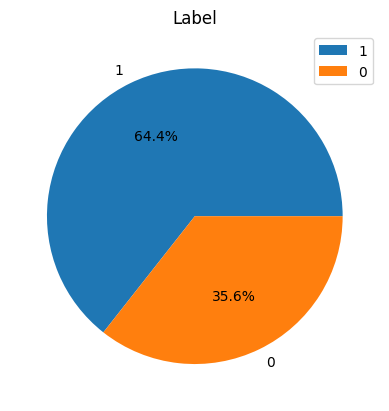

In [34]:
vis.pie(nn, 'label', title= 'Good: 0 Vs Bad: 1')
# plt.title("Good vs bad client")

In [35]:
nn[['label', 'amt_income_total', 'days_employed', 'days_birth']].corr() * 100

,label,amt_income_total,days_employed,days_birth
label,100.000000,2.262300,-0.100807,-0.650755
amt_income_total,2.262300,100.000000,-16.861148,-6.790886
days_employed,-0.100807,-16.861148,100.000000,61.621096
days_birth,-0.650755,-6.790886,61.621096,100.000000


#### __Statistical measure__:  To find the relationship between label and continous variable

In [37]:
null = 'There is no difference between Good and Bad client based on amount income'
alternate = 'There is a difference beween good and bad client based on amount income'

pre.mann_whitney(nn[nn['label']==0]['amt_income_total'], nn[nn['label']==1]['amt_income_total'], null, alternate)

0.0008025808283201101
The mann_whitney test result is statistically significant (p-value = 0.0008025808283201101).
There is a difference beween good and bad client based on amount income


In [38]:
null = 'There is no difference between Good and Bad client based on days employed'
alternate = 'There is a difference beween good and bad client based on days employed'

pre.mann_whitney(nn[nn['label']==0]['days_employed'], nn[nn['label']==1]['days_employed'], null, alternate)

1.734798619186038e-06
The mann_whitney test result is statistically significant (p-value = 1.734798619186038e-06).
There is a difference beween good and bad client based on days employed


In [39]:
null = 'There is no difference between Good and Bad client based on age'
alternate = 'There is a difference beween good and bad client based on age'

pre.mann_whitney(nn[nn['label']==0]['days_birth'], nn[nn['label']==1]['days_birth'], null, alternate)

0.26417589033618605
The mann_whitney test result is not statistically significant (p-value = 0.26417589033618605).
There is no difference between Good and Bad client based on age


# Insights captured: 
- There is a impact of days employed and amount on being a good or bad client

# Answering raised questions

In [40]:
null = "There is no difference between being a good/bad client vs having a work phone"
alternate = "There is no difference between being a good/bad client vs having a work phone"
pre.chi_test(nn, 'label', 'flag_work_phone', null, alternate)

The None test result is not statistically significant (p-value = 0.32937588034037407).
There is no difference between being a good/bad client vs having a work phone


In [41]:
null = "There is no difference between being a good/bad client vs having a phone"
alternate = "There is no difference between being a good/bad client vs having a phone"
pre.chi_test(nn, 'label', 'flag_phone', null, alternate)

The None test result is statistically significant (p-value = 0.023620605528654724).
There is no difference between being a good/bad client vs having a phone


In [42]:
null = "Occupation type has no impact on label (good/bad) client"
alternate = "Occupation type has impact on label (good/bad) client"
pre.chi_test(nn, 'label', 'occupation_type', null, alternate)

The None test result is statistically significant (p-value = 1.0738677144966108e-08).
Occupation type has impact on label (good/bad) client


#### Question:  Which group has higher impact? in occupation type

In [43]:
null = "Family status has no impact on label (good/bad) client"
alternate = "Family status has impact on label (good/bad) client"
pre.chi_test(nn, 'label', 'name_family_status', null, alternate)

The None test result is not statistically significant (p-value = 0.18920239859166835).
Family status has no impact on label (good/bad) client


In [44]:
null = "Education type has no impact on label (good/bad) client"
alternate = "Education type has impact on label (good/bad) client"
pre.chi_test(nn, 'label', 'name_education_type', null, alternate)

The None test result is statistically significant (p-value = 7.125916472382147e-06).
Education type has impact on label (good/bad) client


In [45]:
null = "Own car has no impact on label (good/bad) client"
alternate = "Own car type has impact on label (good/bad) client"
pre.chi_test(nn, 'label', 'flag_own_car', null, alternate)

The None test result is not statistically significant (p-value = 0.9214323864037257).
Own car has no impact on label (good/bad) client


In [46]:
null = "Gender  has no impact on label (good/bad) client"
alternate = "Gender car type has impact on label (good/bad) client"
pre.chi_test(nn, 'label', 'code_gender', null, alternate)

The None test result is not statistically significant (p-value = 1.0).
Gender  has no impact on label (good/bad) client


In [47]:
null = "House  has no impact on label (good/bad) client"
alternate = "House car type has impact on label (good/bad) client"
pre.chi_test(nn, 'label', 'name_housing_type', null, alternate)

The None test result is not statistically significant (p-value = 0.0504698655481088).
House  has no impact on label (good/bad) client


In [48]:
# Drop un required columns
columns = ['id', 'status', 'flag_mobil']
helper.drop_columns(nn, columns, inplace=True)
helper.drop_columns(null_frame, columns, inplace=True)

### Insights caputured
- Columns which has impact on labels is:
    - Education type

- Columns which has no impact on labels are as follow:
    - Family status
    - Own car
    - Gender
    - House type

no_impact_columns = ['name_housing_type', 'code_gender', 'flag_own_car', 'name_education_type',  'name_family_status']